# Исследование эффективности рекламных кампаний приложения

Проведен анализ данных развлекательного приложения Procrastinate Pro+. Несмотря на огромные вложения в рекламу, последние несколько месяцев компания терпит убытки. **Задача** — разобраться в причинах и помочь компании выйти в плюс.

Есть данные о пользователях, привлечённых с 1 мая по 27 октября 2019 года:
* лог сервера с данными об их посещениях,
* выгрузка их покупок за этот период,
* рекламные расходы.

# План исследования:

**1. Изучить общую информация о данных, выполнить преобработку.**

**2. Задать функции для расчета и анализа бизнес-показателей.**

**3. Исследовательский анализ данных:**

* Составить профили пользователей
* Выяснить, из каких стран приходят пользователи и где больше доля платящих пользователей
* Выяснить, какими устройствами пользуются клиенты и для каких больше доля платящих пользователей
* Изучить рекламные источники привлечения и для каких больше доля платящих пользователей

**4. Маркетинговое исследование:**

* Изучить распределение трат по рекламным источникам
* Изучить стоимость привлечения одного пользователя из каждого источника

**5. Оценить окупаемость рекламы:**

* Проанализировать окупаемость рекламы в целом
* Проанализировать окупаемость рекламы в разбивке по устройствам
* Проанализировать окупаемость рекламы в разбивке по странам
* Проанализировать окупаемость рекламы в разбивке по рекламным каналам

### Изучение данных и подготовка к анализу

In [3]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import seaborn as sns
from matplotlib import pyplot as plt

In [4]:
visits, orders, costs = (
    pd.read_csv('visits_info_short.csv'),
    pd.read_csv('orders_info_short.csv'),
    pd.read_csv('costs_info_short.csv')
)

In [5]:
display(visits.head())
print()
display(orders.head())
print()
costs.head()

,User Id,Region,Device,Channel,Session Start,Session End
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40


,User Id,Event Dt,Revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99


,dt,Channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1


In [6]:
print(visits.info())
print()
print(orders.info())
print()
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #

In [7]:
# наличие дубликатов
print(visits.duplicated().sum(), orders.duplicated().sum(), costs.duplicated().sum(), sep='\n')

0
0
0


Дубликатов и пропусков в данных нет.

**Скорректируем названия столбцов.**

In [8]:
visits.columns = visits.columns.str.lower().str.replace(' ', '_')
orders.columns = orders.columns.str.lower().str.replace(' ', '_')
costs = costs.rename(str.lower, axis='columns')

# check
print(visits.columns, orders.columns, costs.columns, sep='\n')

Index(['user_id', 'region', 'device', 'channel', 'session_start',
       'session_end'],
      dtype='object')
Index(['user_id', 'event_dt', 'revenue'], dtype='object')
Index(['dt', 'channel', 'costs'], dtype='object')


In [9]:
# преобразование данных о времени
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
costs['dt'] = pd.to_datetime(costs['dt']).dt.date

In [10]:
#check
print(visits.info())
print()
print(orders.info())
print()
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   user_id        309901 non-null  int64         
 1   region         309901 non-null  object        
 2   device         309901 non-null  object        
 3   channel        309901 non-null  object        
 4   session_start  309901 non-null  datetime64[ns]
 5   session_end    309901 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(3)
memory usage: 14.2+ MB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   40212 non-null  int64         
 1   event_dt  40212 non-null  datetime64[ns]
 2   revenue   40212 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage

**Проверим данные на наличие аномальных значений**

Посмотрим, соответствует ли временной интервал в данных условию проекта.

In [11]:
print(visits['session_start'].min(), visits['session_start'].max())
print(orders['event_dt'].min(), orders['event_dt'].max())
print(costs['dt'].min(), costs['dt'].max())

2019-05-01 00:00:41 2019-10-31 23:59:23
2019-05-01 00:28:11 2019-10-31 23:56:56
2019-05-01 2019-10-27


Верхняя граница временного интервала в данных различается, оставим данные за период, который есть во всех датасетах, то есть ограничим по максимальной дате из датасета costs, которая совпадает с условием из ТЗ.

In [12]:
# зададим 28.10.2019 как максимальную дату, не входящую в срез
max_date = datetime(2019, 10, 28)
visits = visits.loc[visits['session_end'] < max_date]
orders = orders.loc[orders['event_dt'] < max_date]
print(visits['session_start'].max(), orders['event_dt'].max(), sep='\n')

2019-10-27 23:55:42
2019-10-27 23:55:15


Проверим, есть ли аномальные значения длительности сессий пользователей.

count    306206.000000
mean       1800.046720
std        1802.936249
min           0.000000
25%         517.000000
50%        1244.000000
75%        2497.000000
max       22257.000000
Name: session_duration_sec, dtype: float64
Мединана: 1244.0


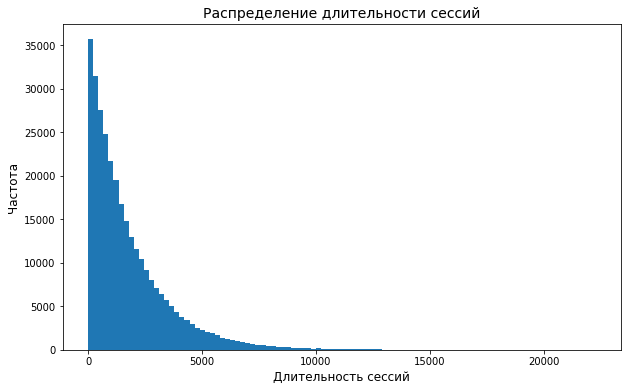

In [13]:
visits['session_duration_sec'] = (visits['session_end'] - visits['session_start']).dt.seconds
visits['session_duration_sec'].plot(kind='hist', bins=100, figsize=(10,6))
plt.title('Распределение длительности сессий', fontsize=14)
plt.xlabel('Длительность сессий', fontsize=12)
plt.ylabel('Частота', fontsize=12);
print(visits['session_duration_sec'].describe())
print(f"Мединана: {visits['session_duration_sec'].median()}")

Больше всего сессий оказалось в районе нулевой длительности, скорее всего эти сессии закончились техническими ошибками, также есть аномально длинные сессии. Оставим для дальнейшего анализа те сеансы, которые длились не менее 30 секунд и не более 5000 секунд (~83 минуты).

In [14]:
visits = visits.loc[(visits['session_duration_sec'] > 30) & (visits['session_duration_sec'] < 5000)]

Проверим есть ли отрицательные или нулевые значения в данных в столбце с доходами и тратами на рекламу.

In [15]:
print(len(orders.loc[orders['revenue'] <= 0]), len(costs.loc[costs['costs'] <= 0]))

0 0


В целом данные не содержат пропусков, в численных данных нет ошибочных и аномальных значений, временной интервал данных соответствует ТЗ.

### Зададим функции для расчёта и анализа LTV, ROI, удержания и конверсии.

In [16]:
# функция для создания профилей пользователей

def get_profiles(sessions, orders, ad_costs):
    
    # параметры первых посещений
    profiles = (
        sessions.sort_values(['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {'session_start': 'first',
             'region': 'first',
             'device': 'first',
             'channel': 'first'
            })
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )
    
    # добавим дату первого посещения и первый день месяца посещения для когортного анализа
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')
    
    # добавим признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())
    
    # считаем уникальных пользователей с одинаковым источником и датой привлечения
    new_users = (
         profiles.groupby(['dt', 'channel'])
         .agg({'user_id' : 'nunique'})
         .rename(columns={'user_id': 'unique_users'})
         .reset_index()
    )
    
    # объединяем траты на рекламу и число привлеченных пользователей в эту дату
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')
    
    # считаем стоимость привлечения одного юзера
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']
    
    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left'
    )
    
    # стоимость привлечения organic пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)
    
    return profiles

In [17]:
# функция для подсчета Retention Rate

def get_retention(profiles, sessions, observation_date, horizon_days, dimensions=[], ignore_horizon=False):
    
    dimensions = ['payer'] + dimensions
    
    # исключаем пользователей, не «доживших» до горизонта событий
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(days=horizon_days - 1)
    result_raw = profiles.query('dt < @last_suitable_acquisition_date')
    
    # собираем сырые данные для расчета удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']).dt.days
    
    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result
        
    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)
    
    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(result_raw, dimensions + ['dt'], horizon_days)
    
    return result_raw, result_grouped, result_in_time

In [18]:
# функция для подсчета конверсии

def get_conversion(profiles, purchases, observation_date, horizon_days, dimensions=[], ignor_horizon=False):
    
    last_suitable_acquisition_date = observation_date
    if not ignor_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(days=horizon_days - 1)
    result_raw = profiles.query('dt < @last_suitable_acquisition_date')
    
    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )
    
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(first_purchases[['user_id', 'event_dt']], on=['user_id'], how='left')
    
    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']
        
    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis=1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        
        # считаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result
    
    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)
    
    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return result_raw, result_grouped, result_in_time 

In [19]:
# функция для подсчета LTV

def get_ltv(profiles, purchases, observation_date, horizon_days, dimensions=[], ignore_horizon=False):
    
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
         
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    ) 

In [20]:
# функция для сглаживания данных

def filter_data(df, window):
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean()
    return df

In [21]:
# функция построения графика Retention Rate

def plot_retention(retention, retention_history, horizon, window=7):
    
    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show() 

In [22]:
# функция построения графика конверсии

def plot_conversion(conversion, conversion_history, horizon, window=7):
    
    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

In [23]:
# функция для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window):
    
    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

### Исследовательский анализ данных

#### Составим профили пользователей.

In [24]:
profiles = get_profiles(visits, orders, costs)
profiles.head()

,user_id,first_ts,region,device,channel,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,United States,Mac,FaceBoom,2019-05-07,2019-05-01,True,1.163218
1,4919697,2019-07-10 22:27:24,United States,iPhone,FaceBoom,2019-07-10,2019-07-01,False,1.157037
2,6085896,2019-10-03 10:08:12,France,iPhone,organic,2019-10-03,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,Germany,PC,AdNonSense,2019-08-22,2019-08-01,False,0.840000
4,31989216,2019-10-02 00:07:44,United States,iPhone,YRabbit,2019-10-02,2019-10-01,False,0.230769


In [25]:
# интервал привлечения пользователей
min_analysis_date = profiles['dt'].min()
max_analysis_date = profiles['dt'].max()
print(min_analysis_date, max_analysis_date, sep='\n')

2019-05-01
2019-10-27


Временной интервал привлечения пользователей соответствует интервалу, заявленному в ТЗ.

#### Распределение пользователей по странам.

In [26]:
def distribution_by_dimension(profiles, dimension: str):
    users_per_dimension = profiles.groupby(dimension).agg({'user_id': 'count', 'payer': 'mean'})
    users_per_dimension = users_per_dimension.rename(columns={'user_id': 'users_total', 'payer': 'share_of_payers'})
    display(users_per_dimension.sort_values(by='share_of_payers', ascending=False).style.format({'share_of_payers' : '{:.1%}'}))

In [27]:
users_per_countries = distribution_by_dimension(profiles, dimension='region')

,users_total,share_of_payers
region,,
United States,95940,7.1%
Germany,14364,4.3%
UK,16855,4.1%
France,16774,3.9%


**Вывод:**

Больше всего пользователей приходят в приложение из США, также на США приходится самая большая доля платящих пользователей (7,1%). Оставшиеся пользователи примерно поровну приходят из таких стран, как Франция, Германия, Великобритания. Процент платящих пользователей среди этих стран равен 3,9 - 4,1%.

#### Распределение пользователей по устройствам.

In [28]:
users_per_device = distribution_by_dimension(profiles, dimension='device')

,users_total,share_of_payers
device,,
Mac,28765,6.5%
iPhone,52318,6.3%
Android,33629,6.0%
PC,29221,5.2%


**Вывод:**

Большинство пользователей заходят в приложение с устройства IPhone, следом по популярности идет Android, за ним с небольшой разницей PC и Mac. При этом наибольшее количество оплат совершается с устройств Mac и IPhone, наименьшее количество оплат приходит с PC.

#### Распределение пользователей по каналам привлечения.

In [29]:
users_per_channel = distribution_by_dimension(profiles, dimension='channel')

,users_total,share_of_payers
channel,,
FaceBoom,27942,12.3%
AdNonSense,3747,11.5%
lambdaMediaAds,2070,10.8%
TipTop,18836,9.9%
RocketSuperAds,4256,8.2%
WahooNetBanner,8224,5.4%
YRabbit,4114,3.9%
MediaTornado,4185,3.7%
LeapBob,8207,3.2%


**Вывод:**

Среди каналов FaceBoom, AdNonSense, lambdaMediaAds и TipTop доля платящих пользователей наибольшая. Меньше всего платящих пользователей от общего количества пришли органически.

**Вывод по разделу:**

В приложение пользователи приходят из таких стран, как США, Германия, Великобритания и Франция. При этом наибольшее количество пользователей приходят из США, и доля платящих пользователей в США наибольшая. 

Большая часть пользователей заходит в приложение с мобильных устройств. Наиболее популярным устройством для захода в приложение является Iphone. Наибольшую конверсию имеют пользователи Mac, а затем следует IPhone. В целом пользователи Apple имеют лучшую конверсию, возможно есть плюсы у ApplePay.

Наибольшее количество пользоватлей приходят в приложение органически, также по количеству пришедших пользователей в тройку входят каналы FaceBoom и TipTop. При этом доля платящих пользователей больше в каналах  FaceBoom, AdNonSense, lambdaMediaAds и TipTop. 

### Маркетинговое исследование

#### Посмотрим, как распределены траты по рекламным источникам.

In [30]:
marketing_total = costs['costs'].sum()
print(f'Общая сумма расходов на маркетинг: {marketing_total:,.2f}')

Общая сумма расходов на маркетинг: 105,497.30


In [31]:
channel_costs = costs.groupby('channel').agg({'costs': 'sum'}).rename(columns={'costs': 'total_cost'})
channel_costs['share'] = channel_costs['total_cost'] / marketing_total
channel_costs.sort_values(by='share', ascending=False).style.format({'total_cost': '{:,.2f}', 'share': '{:.1%}'})

,total_cost,share
channel,,
TipTop,"54,751.30",51.9%
FaceBoom,"32,445.60",30.8%
WahooNetBanner,"5,151.00",4.9%
AdNonSense,"3,911.25",3.7%
OppleCreativeMedia,"2,151.25",2.0%
RocketSuperAds,"1,833.00",1.7%
LeapBob,"1,797.60",1.7%
lambdaMediaAds,"1,557.60",1.5%
MediaTornado,954.48,0.9%


**Вывод:**

Половина всего маркетингового бюджета была потрачена на канал TipTop (51,9%), на Faceboom потратили 30,8% от общего бюджета. На оставшиеся источники было потрачено менее 5% от всего бюджета на каждый канал. Меньше всего потратили на каналы MediaTornado и YRabbit.

Стоит отметить, что несмотря на то, что на канал Faceboom было потрачено меньше бюджета, чем на TipTop, в целом он привел больше пользователей в приложение и доля платящих пользователей у него наибольшая.

#### Динамика изменения расходов во времени.

In [32]:
costs['week'] = costs['dt'].astype('datetime64[W]')
costs['month'] = costs['dt'].astype('datetime64[M]')

In [33]:
costs_week = costs.pivot_table(index='week', columns='channel', values='costs', aggfunc='sum')
costs_month = costs.pivot_table(index='month', columns='channel', values='costs', aggfunc='sum')

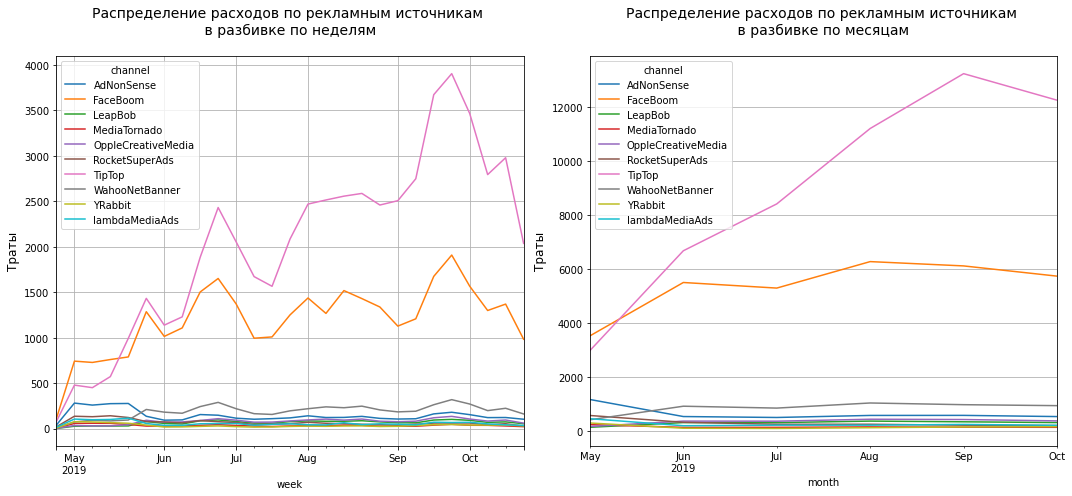

In [34]:
plt.figure(figsize=(15, 7))
ax1 = plt.subplot(1, 2, 1)
costs_week.plot(grid=True, ax=ax1)
plt.title('Распределение расходов по рекламным источникам \n в разбивке по неделям \n', fontsize=14)
plt.ylabel('Траты', fontsize=12)
ax2 = plt.subplot(1, 2, 2,)
costs_month.plot(grid=True, ax=ax2)
plt.title('Распределение расходов по рекламным источникам \n в разбивке по месяцам \n', fontsize=14)
plt.ylabel('Траты', fontsize=12)
plt.tight_layout();

**Вывод:**

По объему выделяемого рекламного бюджета лидируют TipTop и FaceBoom. В первой половине мая выделяли больше рекламного бюджета на канал FaceBoom, затем стали стремительно наращивать канал TipTop. Во второй половине сентября на TipTop было потрачено максимальное количество бюджета. При этом траты на канал Faceboom за весь период были примерно на одном уровне, но в сентябре также есть небольшой всплеск. 

На остальные каналы бюджета выделили намного меньше и тратили его равномерно. Однако есть небольшой всплеск бюджета в мае у канала AdNonSense, а с июня по конец октября чуть больше тратили на канал WahooNetBanner.

#### Стоимость привлечения одного пользователя из каждого источника.

Посчитаем среднюю стоимость привлечения пользователя для каждого канала.

In [35]:
(
    profiles.groupby('channel')
        .agg({'acquisition_cost': 'mean'})
        .rename(columns={'acquisition_cost': 'mean_acquisition_cost'})
        .sort_values(by='mean_acquisition_cost', ascending=False)
)

,mean_acquisition_cost
channel,
TipTop,2.906737
FaceBoom,1.161177
AdNonSense,1.043835
lambdaMediaAds,0.752464
WahooNetBanner,0.626338
RocketSuperAds,0.430686
OppleCreativeMedia,0.261677
YRabbit,0.229514
MediaTornado,0.228072


В среднем наиболее высокая стоимость привлечения пользователя у канала TipTop (2,9 у.е.), у FaceBoom и AdNonSense 1 у.е. Наиболее дешевые пользователи приходят через каналы OppleCreativeMedia, YRabbit, MediaTornado, LeapBob (менее 0,26 у.е.).

Посмотрим как менялась CAC в динамике.

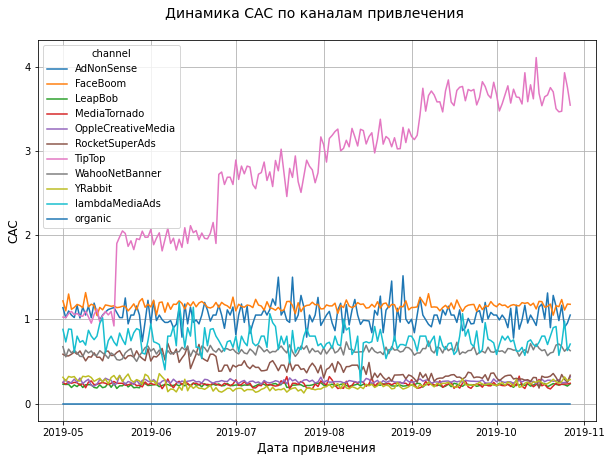

In [36]:
profiles.pivot_table(
    index='dt', columns='channel', values='acquisition_cost', aggfunc='mean'
).plot(grid=True, figsize=(10,7))
plt.ylabel('CAC', fontsize=12)
plt.xlabel('Дата привлечения', fontsize=12)
plt.title('Динамика CAC по каналам привлечения \n', fontsize=14)
plt.show()

**Вывод:**

Стоимость привлечения одного пользователся для канала TipTop оказалась самой высокой. Начиная со второй половины мая CAC увеличивалась каждый месяц, и с 1 у.е. выросла до 3,5 у.е. к концу октября. Это может быть связано с тем, что в TipTop более молодая аудитория и соответственно менее платежеспособная. Для FaceBoom CAC на протяжении всего периода равна 1,1 у.е., для канала AdNonSense CAC находится на уровне 1 у.е. У канала RocketSuperAds CAC за весь период снизилась с 0,5 у.е. до 0,25 у.е. Для остальных каналов CAC в среднем не менялась и была ниже 0,7 у.е.

У канала organic CAC ожидаемо равна нулю.

### Анализ окупаемости рекламы

#### Рассмотрим окупаемость рекламы.

In [37]:
observation_date = datetime(2019, 11, 1).date()
if observation_date > max_analysis_date:
    observation_date = max_analysis_date
horizon_days = 14

Исключим органических пользователей из дальнейшего исследования, так как на них не тратится рекламных бюджет и на окупаемость рекламы они не влияют.

In [38]:
profiles = profiles.query('channel != "organic"')

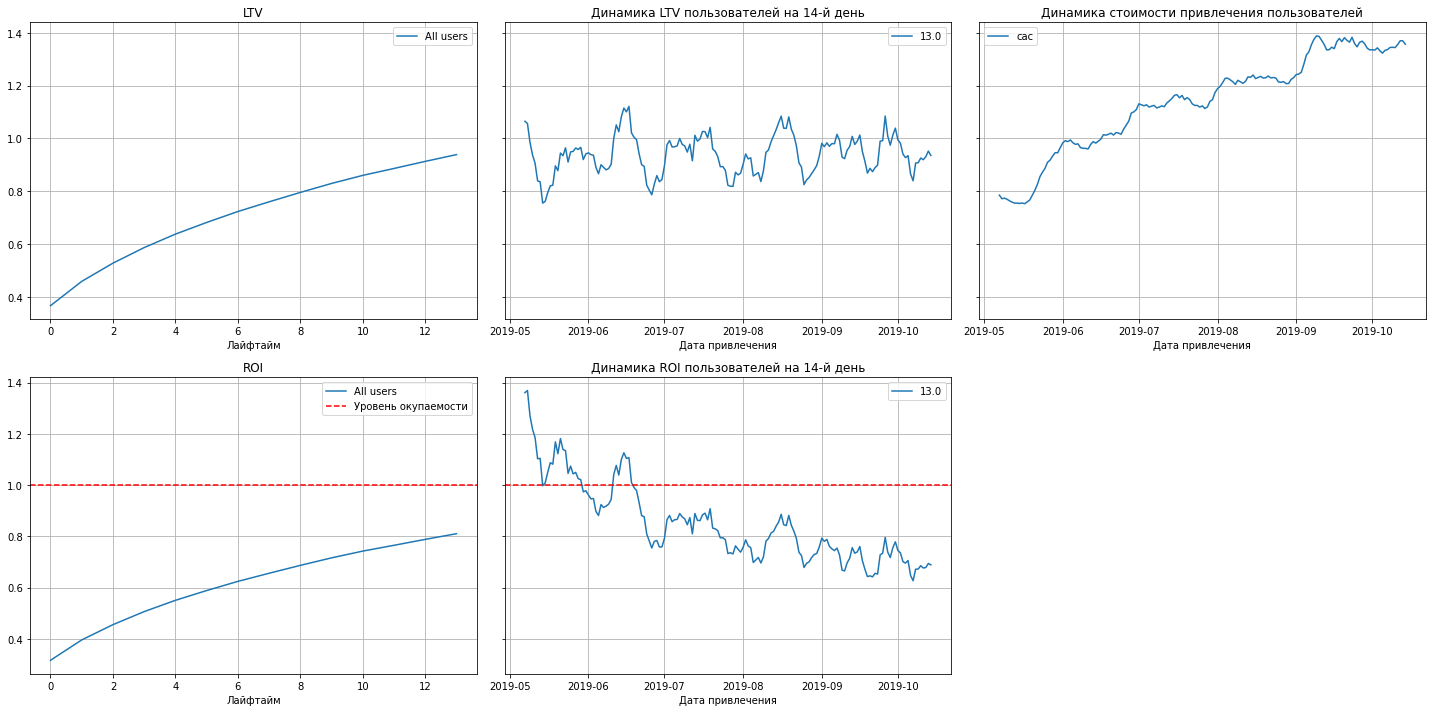

In [39]:
# считаем LTV и ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days)

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=7)

**Вывод:**

* В целом реклама не окупается. ROI к концу второй недели достигает только 80%. При этом для пользователей привлеченных в мае ROI 14-го дня был выше линии окупаемости, далее идет резкий спад в начале июня и небольшой подъем в середине месяца, а затем ROI начинает снижаться с каждым месяцем. 
* CAC постепенно растет, то есть рекламный бюджет увеличивается, а количество платных пользователей растет медленнее.
* LTV достаточно стабилен на протяжении всего рассматриваемого интервала времени. 

#### Рассмотрим конверсию пользователей.

In [40]:
# считаем конверсию пользователей
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days)

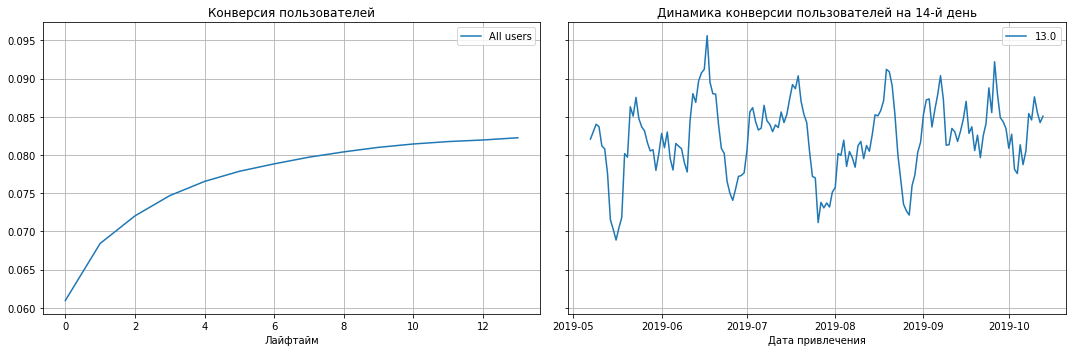

In [41]:
# строим графики конверсии

plot_conversion(conversion_grouped, conversion_history, horizon_days)

**Вывод:**

В целом конверсия постепенно растет на протяжении двух недель. Конверсия 14-го дня в среднем стабильна.

#### Рассмотрим удержание пользователей.

In [42]:
# считаем удержание пользователей
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days)

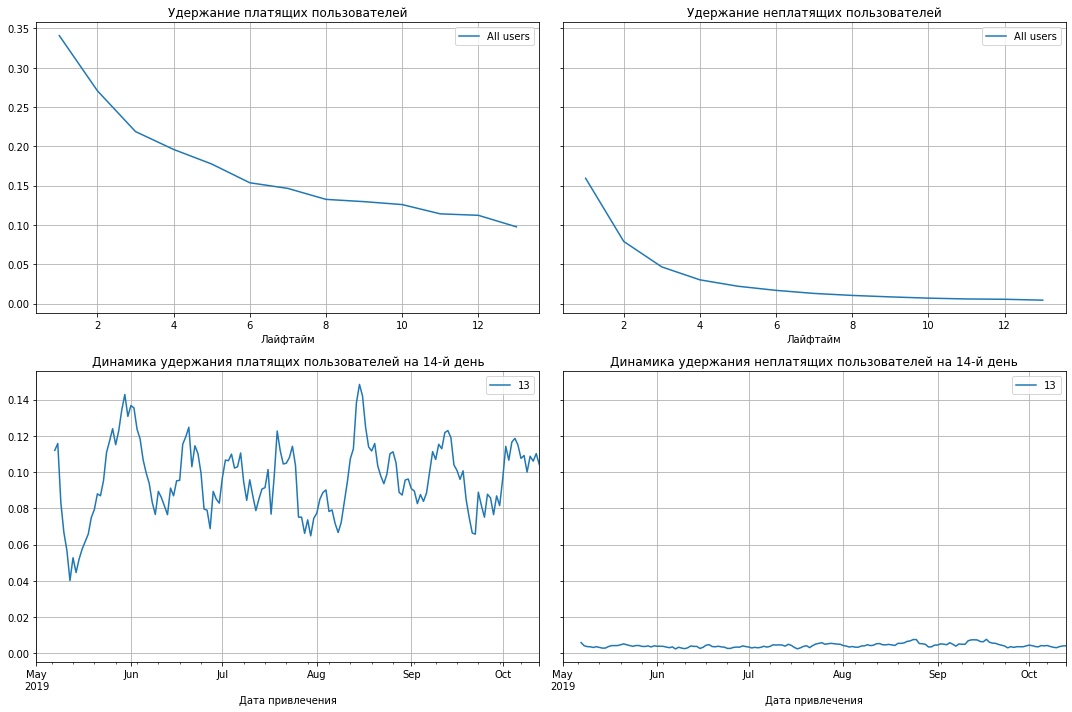

In [43]:
# строим графики удержания с разбивкой на платящих и неплатящих пользователей
plot_retention(retention_grouped, retention_history, horizon_days)

**Вывод:**

Для неплатящих пользователей удержание 14-го дня практически равно нулю. Возможно это как-то связано с наличием пробного периода приложения и после него пропадает доступ к ряду ключевых функций или в целом у неплатящих пользователей нет каких-то функций и у них нет возможности заинтересоваться продуктом.

Для платящих пользователей динамика удержания 14-го дня в среднем стабильна на протяжении всего рассматриваемого интервала. Стоит отметить, что для платящих пользователей, привлеченных в конце первой половины мая удержание 14-го дня оказалось наиболее низким.

#### Рассмотрим окупаемость рекламы с разбивкой по устройствам.

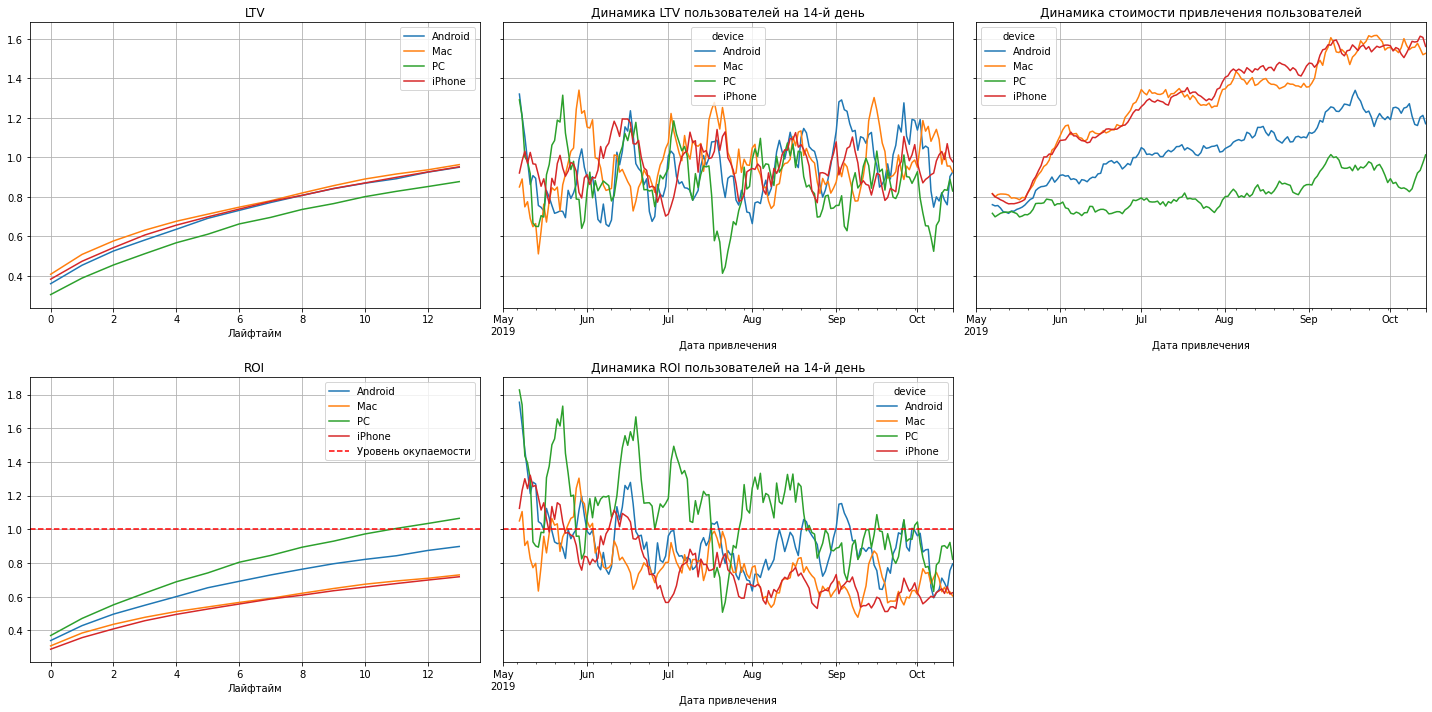

In [44]:
dimensions = ['device']

# считаем LTV и ROI с разбивкой по устройствам
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions)

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=7)

**Вывод:**

* Лучше всего окупается реклама для пользователей PC, но в динамике видно, что и она перестает окупаться, начиная с сентября.
* Наименьшая стоимость привлечения оказалась у пользователей PC, у пользователей Mac и IPhone CAC наиболее высокая.
* LTV 14-го дня стабилен для пользователей всех устройств и находится примерно на одном уровне.
* LTV для пользователей PC в среднем немного ниже, чем для пользователей других устройств.


#### Рассмотрим окупаемость рекламы с разбивкой по странам.

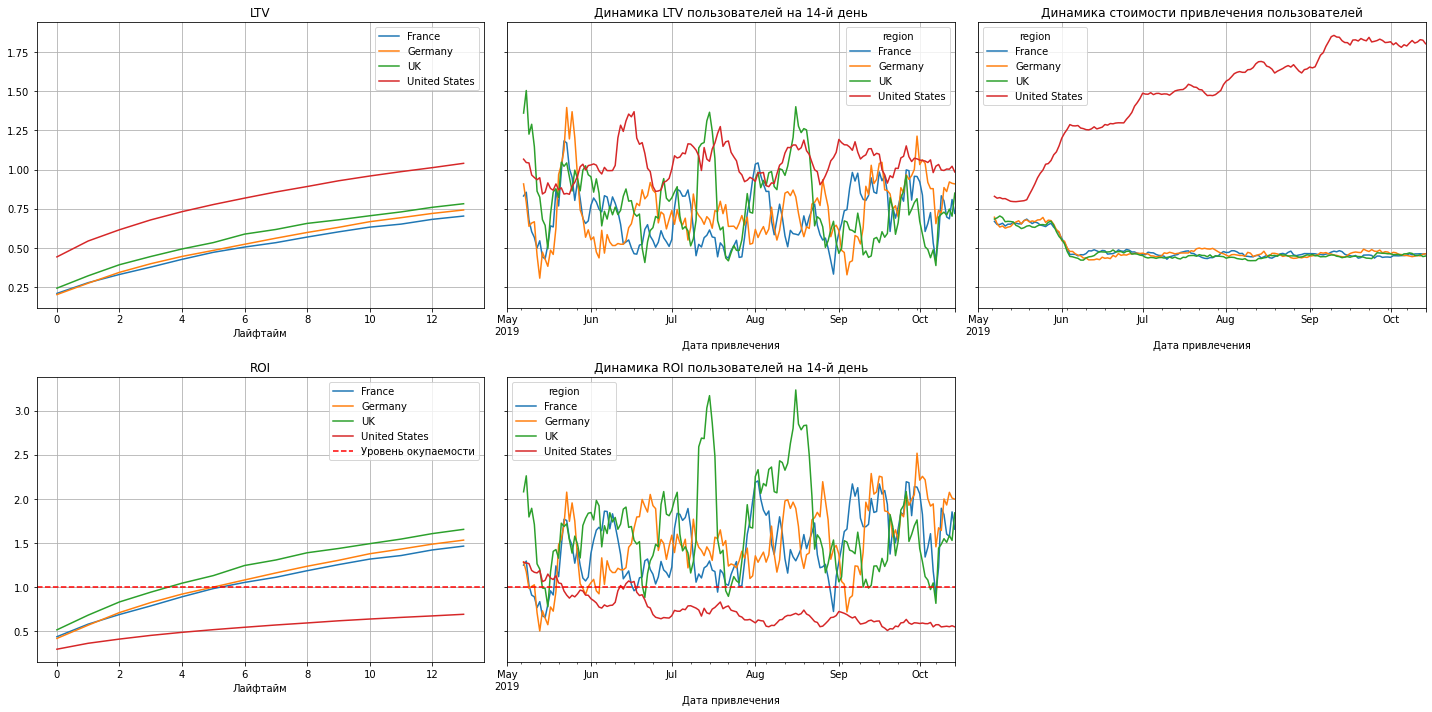

In [45]:
dimensions = ['region']

# считаем LTV и ROI с разбивкой по странам
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions)

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=7)

**Вывод:**

Начиная с июня не окупаются пользователи из США, для других стран ROI стабильно выше уровня окупаемости. LTV у пользователей США наиболее высокий, но также и CAC выше в 3-4 раза. Стоит отметить, что в июне CAC в США начал резко расти, в то время как в оставшихся странах этот показатель снизился.

#### Рассмотрим окупаемость рекламы с разбивкой по рекламным каналам.

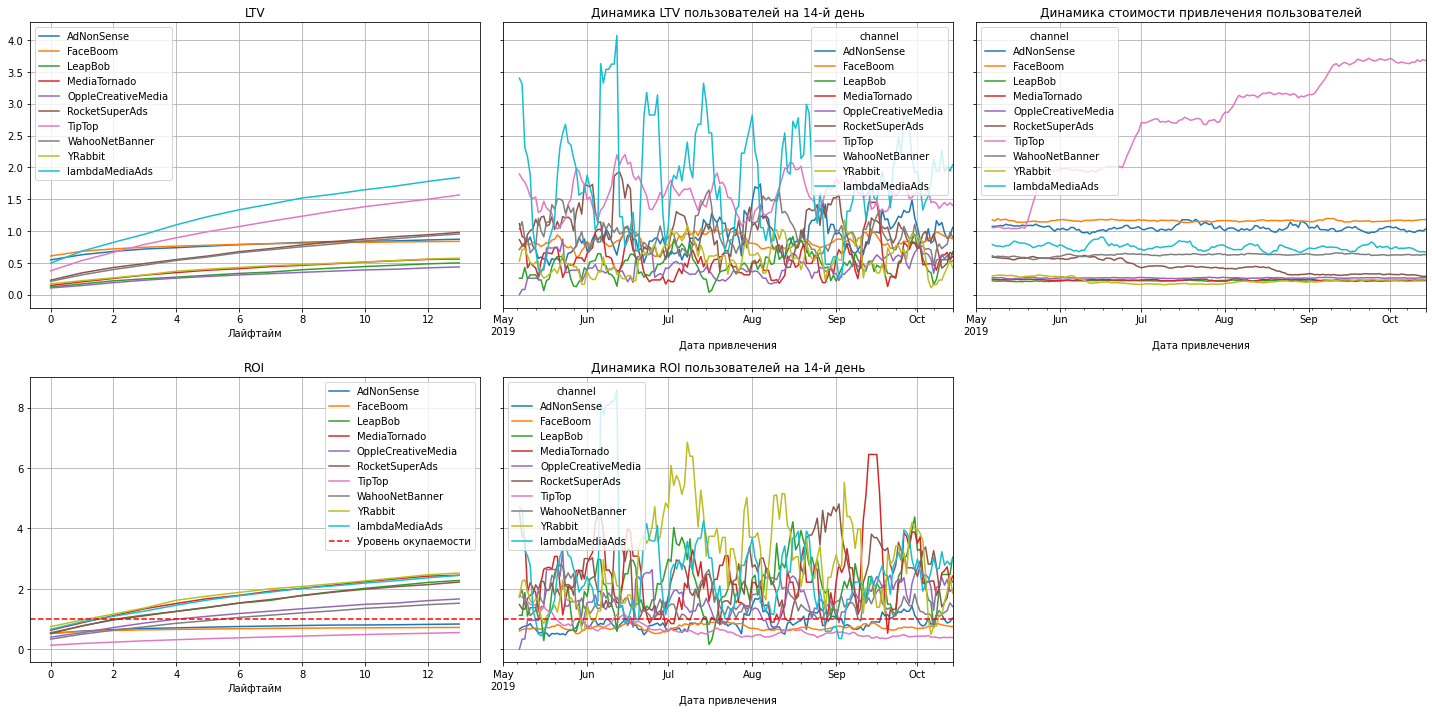

In [46]:
dimensions = ['channel']

# считаем LTV и ROI с разбивкой по рекламным каналам
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions)

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=7)

**Вывод:**

* Реклама в TipTop не окупается, ROI к концу второй недели чуть выше 50%, также не окупается реклама в AdNonSense и FaceBoom. Наибольшее ROI в YRabbit и MediaTornado.
* ROI 14-го дня у TipTop и FaceBoom стабильно ниже уровня окупаемости. У канала YRabbit в свою очередь ROI наиболее высокий.
* Стоимость привлечения значительно выше в TipTop и с каждым месяцем увеличивается. Для остальных каналов стоимость привлечения стабильна.
* Наибольший LTV у пользователей пришедших через lambdaMediaAds, также высокий LTV у пользователей пришедших из TipTop. У пользователей пришедших из FaceBoom и AdNonSense LTV наиболее высокий в первые два дня, а затем практически не меняется, то есть данные каналы начиная с 3 дня перестают приносить прибыль.

**Посмотрим на окупаемость рекламы в США с рабивкой по каналам.**

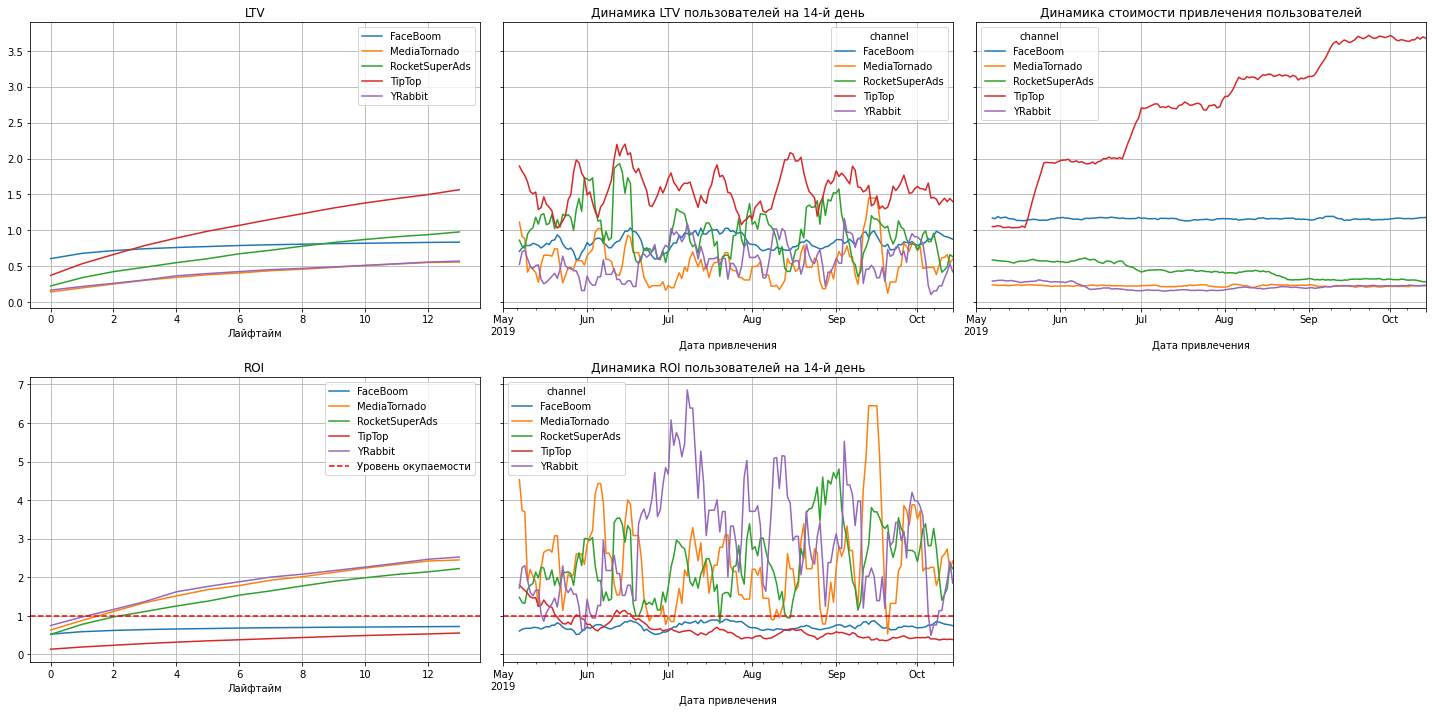

In [47]:
dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles[profiles['region'] == 'United States'], orders, observation_date, horizon_days, dimensions=dimensions)

plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=7)

Cильно проседает окупаемость каналов TipTop и FaceBook. У TipTop это связано с высоким CAC, у FaceBoom CAC также достаточно высокий, при этом LTV, начиная с 3-го дня жизни практически не увеличивается. В свою очередь канал YRabbit и MediaTornado стабильно окупается на протяжении всей рекламной кампании.

**Посмотрим на удеражание пользователей в США в разбивке по каналам**

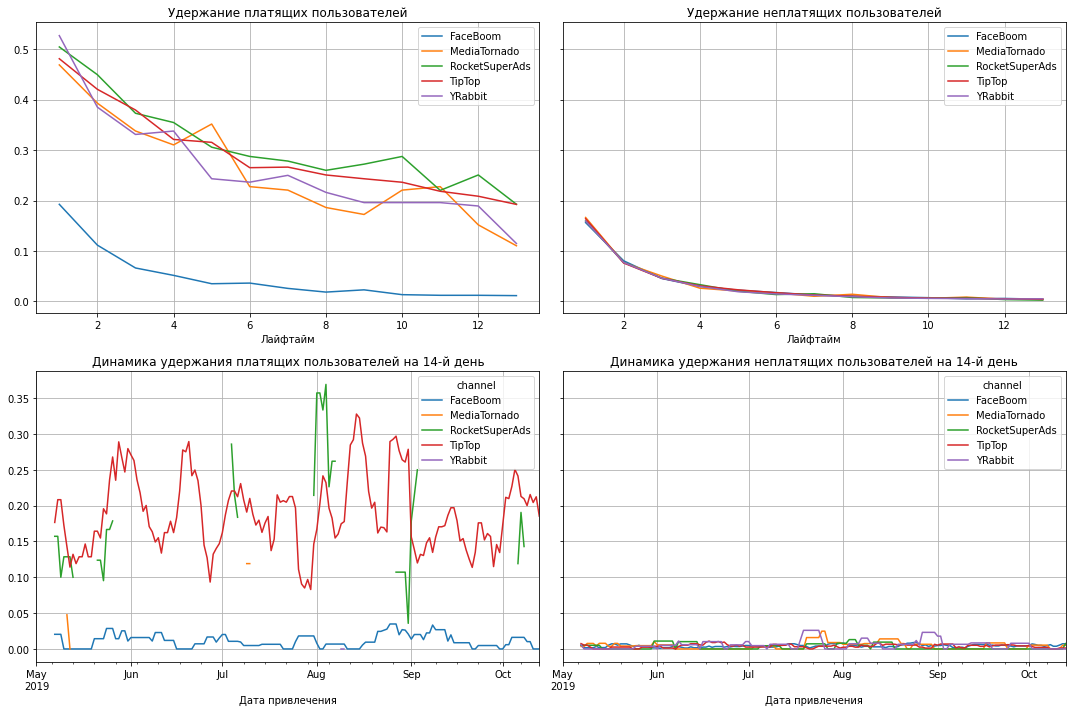

In [48]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles[profiles['region'] == 'United States'], visits, observation_date, horizon_days, dimensions=['channel'])

plot_retention(retention_grouped, retention_history, horizon_days)

Удержание для пользователей, пришедших в приложение через FaceBoom, намного ниже по сравнению с другими каналами, а к 14-му дню оно сводится к нулю.

**Общий вывод по разделу:**

1. В целом реклама, направленная на привлечение пользователей не окупается. Это связано с резким ростом CAC в июне, так как LTV на протяжении всего времени стабилен. 

2. На общую окупаемость негативнее всего влияет окупаемость рекламы в США, явные проблемы присутствуют у каналов TipTop и FaceBoom. Начиная с июня в TipTop резко вырос CAC и несмотря на наиболее высокие показатели LTV, ROI  не достигал уровня окупаемости на протяжении всего периода. У FaceBoom CAC также достаточно высок, при этом LTV со временем практически не увеличивается, несмотря на выскоие показатели в первые 2-3 дня. Среди устройств наихудшую окупаемость показали Mac и Iphone.

### Общий вывод


1. Большая часть бюджета (~83%) тратится на неэффективные каналы TipTop и FaceBoom в США. TipTop привлекает достаточно вовлеченных пользователей, но стоимость их привлечения слишком высока, чтобы окупить затраты. FaceBoom приводит пользователей, которые быстро прекращают использовать приложение и также не окупаются.


2. **Рекомендации:**

* Для канала TipTop необходимо выяснить с чем связан резкий рост стоимости привлечения пользователя. Возможно необходимо скорректировать таргетинги (не пытаться привести как можно больше пользователей, а приводить тех, кто будет более заинтересован), либо попробовать другие форматы рекламы.
* FaceBoom приводит пользователей, которые быстро теряют интерес к приложению. Возможно то, что они видят в рекламе не соответсвует их ожиданиям. В этом канале стоит проверить рекламные объявления, а также можно попробовать другие форматы и таргетинги.
* Возможно стоит перераспределить бюджет с неэффективных каналов на те, что приводили достаточно большое количество платящих пользователей: AdNonSense, lambdaMediaAds, RocketSuperAds, или те, что показали высокую окупаемость в США: YRabbit и MediaTornado.